In [2]:
from pdf2image import convert_from_path
from skimage.segmentation import flood, flood_fill
import numpy as np
import cv2
import os
import pytesseract
from pytesseract import Output
import matplotlib.pyplot as plt

In [3]:
def plot(data, name, g=False, save=True, os=False):
    if not os:
        data = cv2.resize(data.copy(), shape[:-1][::-1])
    plt.imshow(data, cmap="gray" if g else None)
    plt.title(name, fontdict={'fontsize': 20})
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(save_path + "/" + name + ".png", dpi=300)

# Magic preproc 

In [5]:
path = "Floor_Plans/Z├╝rich II - 2/ZRH_II-02_01_IST_20140924.pdf"
save_path = path.replace(".pdf", "").replace("Floor_Plans/", "Floor_Plans_preproc/")
os.makedirs(save_path, exist_ok=True)

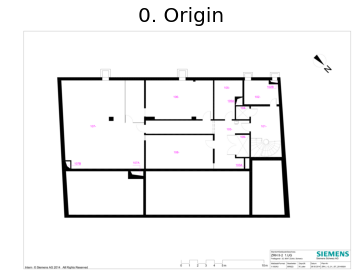

In [6]:
images = convert_from_path(path)
assert len(images) == 1
image = np.array(images[0])
shape = image.shape
plot(image, "0. Origin")

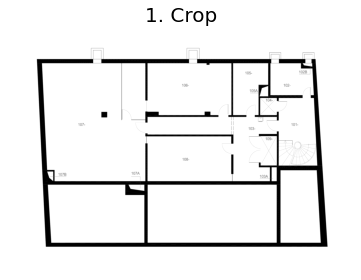

In [7]:
image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
image = image[250:2000, 250:2900]
plot(image, "1. Crop", g=True)

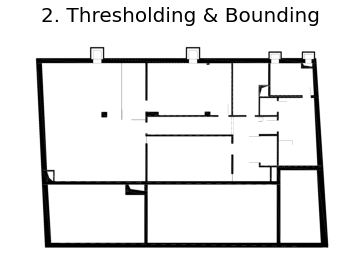

In [9]:
image[image != 0] = 255

border_mask = cv2.erode(image, np.ones((5, 5), np.uint8), iterations=1)
border_mask = flood_fill(border_mask, (0, 0), 127)
border_mask[border_mask != 127] = 0 
border_mask[border_mask == 127] = 255
border = ~cv2.Canny(border_mask, 0, 255)
border = cv2.erode(border, np.ones((5, 5), np.uint8), iterations=2)
image = image & border

ret, image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY|cv2.THRESH_OTSU)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,1))
image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)

plot(image, "2. Thresholding & Bounding", g=True)

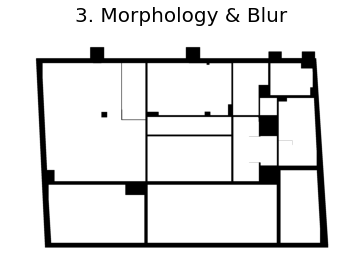

In [10]:
kernel = np.ones((3,3),np.uint8)
image = cv2.erode(image, kernel, iterations=50)

image = cv2.dilate(image, kernel,iterations=50)
plot(image, "3. Morphology & Blur", g=True)

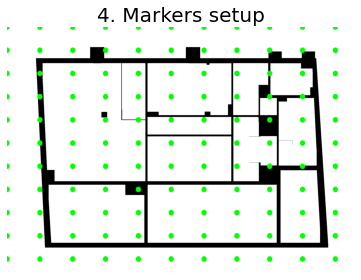

In [11]:
step_y = 250
step_x = int(image.shape[0] / image.shape[1] * 250)

X, Y = np.mgrid[
    0 : image.shape[0] : step_x, 
    0 : image.shape[1] : step_y
]
grid = np.vstack([X.ravel(), Y.ravel()])

markes_image = image.copy()
markes_image = cv2.cvtColor(markes_image, cv2.COLOR_GRAY2BGR)
for p in grid.T:
    markes_image = cv2.circle(markes_image, p[::-1], radius=20, color=(0, 255, 0), thickness=-1)
plot(markes_image, "4. Markers setup")

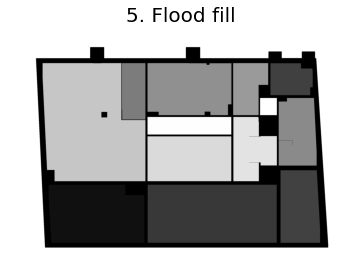

In [12]:
filled_image = image.copy()
idx = 10
for p in grid.T:
    filled_image = flood_fill(filled_image, tuple(p), idx)
    idx += 10
    
background_idx = filled_image[0][0]

filled_image[filled_image == background_idx] = 255
filled_image[image == 0] = 0
plot(filled_image, "5. Flood fill", g=True)

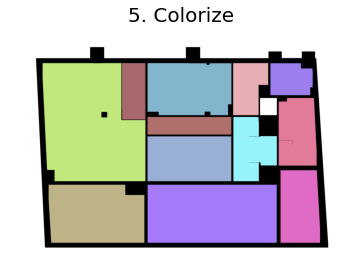

In [13]:
indexes = set(filled_image.flatten())  
n_rooms = len(indexes)
colorized =  cv2.cvtColor(filled_image.copy(), cv2.COLOR_GRAY2BGR)

for i in indexes:
    colorized[filled_image == i] = [np.random.randint(100, 255) for _ in range(3)]

colorized[filled_image == 255] = [255, 255, 255]
colorized[image == 0] = [0, 0, 0]
        
plt.imshow(colorized)
plot(colorized, "5. Colorize", g=False)

# Parse pix/metr

Pix/metr=78.0


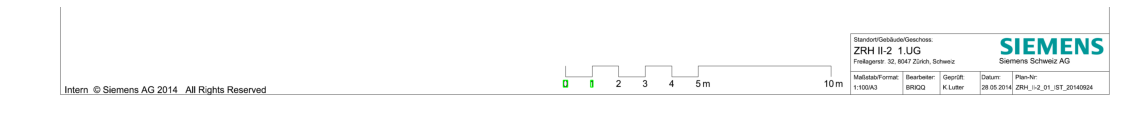

In [27]:
def is_pattern(c1, c2):
    if c1.isdigit() and c2.isdigit() and int(c1) + 1 == int(c2):
        return 0
    if c1 == '5m' and c2 == '10m':
        return 1
    return -1

def draw_rect(img, x, y, w, h):
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

    
images = convert_from_path(path)
assert len(images) == 1
image = np.array(images[0])
shape = image.shape

image_crop = image[-300:]
image_crop_draw = image_crop.copy()
data = pytesseract.image_to_data(image_crop, output_type=Output.DICT)
for i in range(len(image_data['level']) - 1):
    condition = is_pattern(data['text'][i], data['text'][i+1])
    if condition == -1:
        continue
    else:
        delim = 1 if condition == 0 else 5
    
        box_0 = (data['left'][i],   data['top'][i],   data['width'][i],   data['height'][i])
        box_1 = (data['left'][i+1], data['top'][i+1], data['width'][i+1], data['height'][i+1])

        draw_rect(image_crop_draw, *box_0)
        draw_rect(image_crop_draw, *box_1)
        
        mid_0 = box_0[0] + int(box_0[2] / 2)
        mid_1 = box_1[0] + int(box_1[2] / 2)
        pix_per_met = (mid_1 - mid_0) / delim
        break

print(f"Pix/metr={pix_per_met}")
plt.figure(figsize = (20,2))
plt.axis("off")
plt.imshow(image_crop_draw)
pass